<a href="https://colab.research.google.com/github/MortezaNosratpour/CPE-in-BNN/blob/main/Data_Augmentation_Imapct_on_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
from torch import nn
from torchvision import transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
torch.manual_seed(17)

In [ ]:
class TransferFeatures(nn.Module):
  def __init__(self, original_model, classifier, model_name):
    super(TransferFeatures, self).__init__()

    self.features = original_model.features
    print(self.features)
    self.classifier = classifier
    self.modelName = model_name

    #freezing those weights
    for f in self.features.parameters():
      f.requires_grad = False
    

  def forward(self, x):
    f = self.features(x)
    #flattening network
    f =  f.view(f.size(0), np.prod(f.shape[1:]))
    y = self.classifier(f)
    return y


In [ ]:
from os import register_at_fork
from torchvision import models
import torch.optim as optim
from torchvision.transforms import ToTensor

model = models.alexnet(pretrained=True)
classifier = nn.Sequential(
    nn.Dropout(),
    nn.Linear(256 * 6 * 6, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, 10),
)

refit_model = TransferFeatures(model, classifier, 'transfer')

def transform(image):
  image = image.resize((224, 224)).convert('RGB')
  tensor = ToTensor()(image)
  return tensor

train_data = datasets.MNIST(root='./data', train=True, download=True, transform = transform)
batch_size = 4
data_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=1)
classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(refit_model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [ ]:
epochs = 1
losses = []
for epoch in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(data_loader, 0):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = refit_model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 0:   
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
      losses.append(running_loss)
      running_loss = 0.0

torch.save(refit_model, 'fitted.pth')
print("Finished Training!")

In [ ]:
losses = np.array(losses)
losses.tofile("saved_losses")

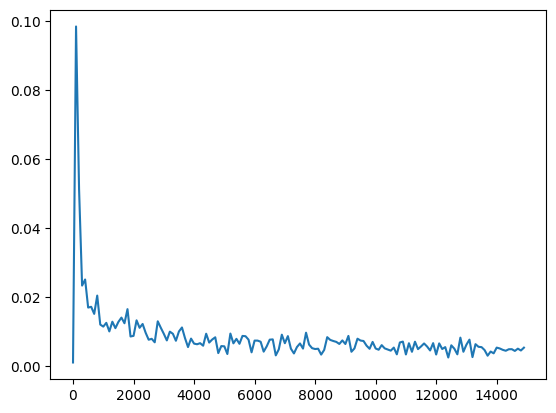

In [ ]:
losses = np.fromfile("saved_losses")
plt.plot(np.arange(1, len(losses)*100, 100),losses/2000)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd 

model = torch.load('fitted.pth')

def transform(img):
  img = img.resize((224, 224)).convert('RGB')
  tensor = ToTensor()(img)
  return tensor

test_data = datasets.MNIST(root = './data', train = False, transform = transform)
batch_size = 4
data_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size, shuffle=True, num_workers=1)


model.eval()
y_trues = []
y_preds = []
torch.multiprocessing.set_sharing_strategy('file_system')
for i, data in enumerate(data_loader, 0):
    inputs, labels = data
    y_trues.append(int(labels[0]))
    out = model(inputs)
    # get the most probable label
    _, index = torch.topk(out, 1)
    y_preds.append(int(index[0]))


FileNotFoundError: ignored

In [ ]:
print(confusion_matrix(y_trues, y_preds))

[[252   0   0   0   0   0   0   2   0   0]
 [  0 282   0   0   0   0   0   0   0   0]
 [  0   0 275   0   0   0   0   1   0   0]
 [  0   0   2 236   0   0   0   1   0   0]
 [  0   3   1   0 253   0   0   4   0   0]
 [  0   0   1   7   0 202   1   0   0   0]
 [  1   1   0   0   0   0 227   0   1   0]
 [  0   0   1   0   0   0   0 258   0   1]
 [  0   0   0   0   0   0   0   0 248   0]
 [  0   1   0   0   0   0   0   0   3 235]]


In [ ]:
print(classification_report(y_trues, y_preds))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       254
           1       0.98      1.00      0.99       282
           2       0.98      1.00      0.99       276
           3       0.97      0.99      0.98       239
           4       1.00      0.97      0.98       261
           5       1.00      0.96      0.98       211
           6       1.00      0.99      0.99       230
           7       0.97      0.99      0.98       260
           8       0.98      1.00      0.99       248
           9       1.00      0.98      0.99       239

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500



In [ ]:
def plot_set_images(n_row, n_col, images, labels, label_text="Label: "):
  num=len(images)
  num_row=n_row
  num_col=n_col
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  for i in range(num):
      ax = axes[i//num_col, i%num_col]
      # ax.imshow(images[i].permute(1, 2, 0), cmap='gray_r')
      ax.imshow(images[i].permute(1, 2, 0), cmap='Greys', vmin=0, vmax=255)
      ax.set_title('{}{}'.format(label_text, labels[i]))
  plt.tight_layout()
  plt.show()

images_set = []
labels_set = []

# for i in range(10):
#   images_set.append(test_data[i][0])
#   labels_set.append(test_data[i][1])
# plot_set_images(2, 5, images_set, labels_set, "Label: ")


In [ ]:
from torchvision.transforms.autoaugment import AutoAugmentPolicy

torch.manual_seed(38)
auto_aug_policy = transforms.Compose([
                    transforms.AutoAugment(AutoAugmentPolicy.CIFAR10),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.1306], std=[0.3081])
                ])

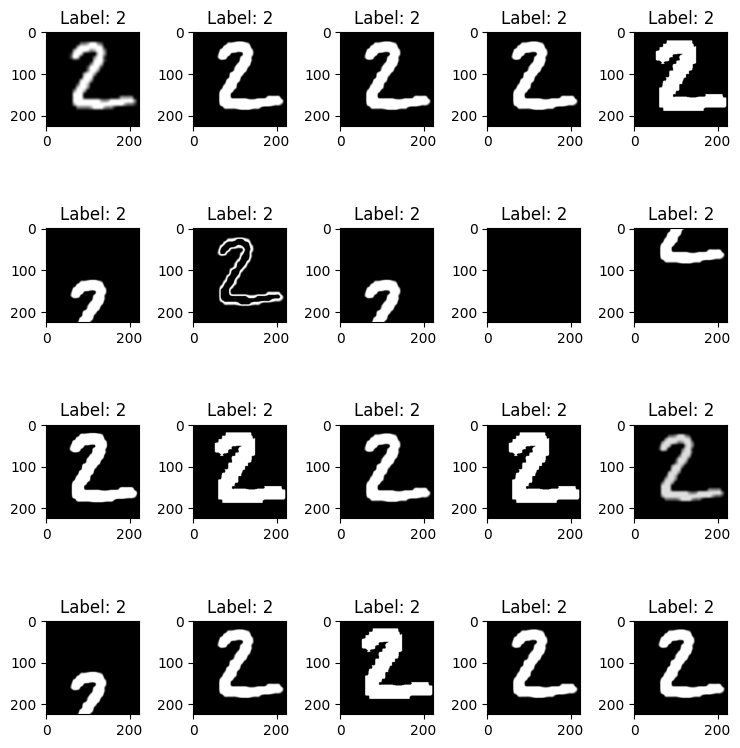

In [ ]:
n=20

test_data = datasets.MNIST(root = './data', train = False, transform = transform)
clean_image = test_data[1][0]
trans_t2PIL = transforms.ToPILImage()
image = trans_t2PIL(clean_image)
augmented_images = []
labels = []
augmented_images.append(clean_image)
labels.append(test_data[1][1])
for i in range(1, n):
  augmented_images.append(auto_aug_policy(image))
  labels.append(test_data[1][1])

plot_set_images(4, 5, augmented_images, labels, "Label: ")

In [ ]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision import io

def transform(image):
  image = image.resize((224, 224)).convert('RGB')
  tensor = ToTensor()(image)

  return tensor

test_data = datasets.MNIST(root='./test_data', train=False, download=True, transform = transform)


def augmented_data_maker(num_of_augmentation = 2, policy=auto_aug_policy):
  X = [test_data[i][0] for i in range(len(test_data))]
  y = [test_data[i][1] for i in range(len(test_data))]
  c = 0
  aug_y = [] 
  os.makedirs('new_augmented_test_data/images', exist_ok=True)
  trans = transforms.ToPILImage()
  for image, label in tqdm(zip(X, y)):
    for i in range(num_of_augmentation):
      image = trans(image)
      image = policy(image)
      img = trans(image)
      img.save('new_augmented_test_data/images/saved_{}.jpg'.format(c), "JPEG")  
      aug_y.append(label)
      c += 1

  
  return aug_y

In [ ]:
from torchvision.transforms.autoaugment import AutoAugmentPolicy
from tqdm import tqdm
model = torch.load('/content/drive/MyDrive/Colab Notebooks/fitted.pth')

y = augmented_data_maker(2, auto_aug_policy)

10000it [02:44, 60.65it/s]


In [ ]:
from torch.utils.data import Dataset, DataLoader
labels = y
class AugmentedData(Dataset):
    def __init__(self):
      super(AugmentedData, self).__init__()
      self.X = [io.read_image('new_augmented_test_data/images/saved_{}.jpg'.format(i)).float() for i in range(1, 20000, 2)]
      self.y = [labels[j] for j in range(1, 20000,2)] 
      
    def __getitem__(self, index) :
      return self.X[index], self.y[index]
                                    
    def __len__(self):
      return len(self.y)

In [ ]:
batch_size = 4

aug_data = AugmentedData()

data_loader = torch.utils.data.DataLoader(aug_data,batch_size=batch_size, shuffle=True, num_workers=1)
model.eval()
y_trues = []
y_preds = []
mislabeled_image=[]
torch.multiprocessing.set_sharing_strategy('file_system')
for data in tqdm(data_loader):
    inputs, labels = data
    y_trues.append(int(labels[0]))
    out = model(inputs)
    # get the most probable label
    _, index = torch.topk(out, 1)
    y_preds.append(int(index[0]))
    if int(labels[0])!= int(index[0]):
      mislabeled_image.append((data, int(labels[0]), int(index[0])))


100%|██████████| 2500/2500 [07:39<00:00,  5.44it/s]


In [ ]:
np.array(labels).tofile("new_augmented_test_data/labels")
# np.array(mislabeled_image).tofile("mislabeled_images")

In [ ]:
!zip -r /content/new_augmented_test_data.zip /content/new_augmented_test_data

In [ ]:
print(len(mislabeled_image))
x, y, z = mislabeled_image[0]
print(x[1], y, z)

1639
tensor([5, 6, 5, 1]) 5 6


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_trues, y_preds))

[[121  13   9   0   0   3  63   1  27   5]
 [ 16 123   3   1   0   1  61   2  84   7]
 [  9  37  83   0   0   5  51   0  76   6]
 [  9  27  10  23   0  14  34   1 131   5]
 [ 11  46  15   1   6   0  75   1  87  16]
 [ 12  22  12   1   1  26  83   0  55   7]
 [  2  25   7   1   1   1 172   1  34   1]
 [  9  67   5   1   0   4  40  24  38  38]
 [  1  18   6   1   0   0  31   0 183   6]
 [  8  29   3   0   0   1  44   0  60 100]]


In [ ]:
print(classification_report(y_trues, y_preds))

              precision    recall  f1-score   support

           0       0.61      0.50      0.55       242
           1       0.30      0.41      0.35       298
           2       0.54      0.31      0.40       267
           3       0.79      0.09      0.16       254
           4       0.75      0.02      0.05       258
           5       0.47      0.12      0.19       219
           6       0.26      0.70      0.38       245
           7       0.80      0.11      0.19       226
           8       0.24      0.74      0.36       246
           9       0.52      0.41      0.46       245

    accuracy                           0.34      2500
   macro avg       0.53      0.34      0.31      2500
weighted avg       0.53      0.34      0.31      2500



264


IndexError: ignored

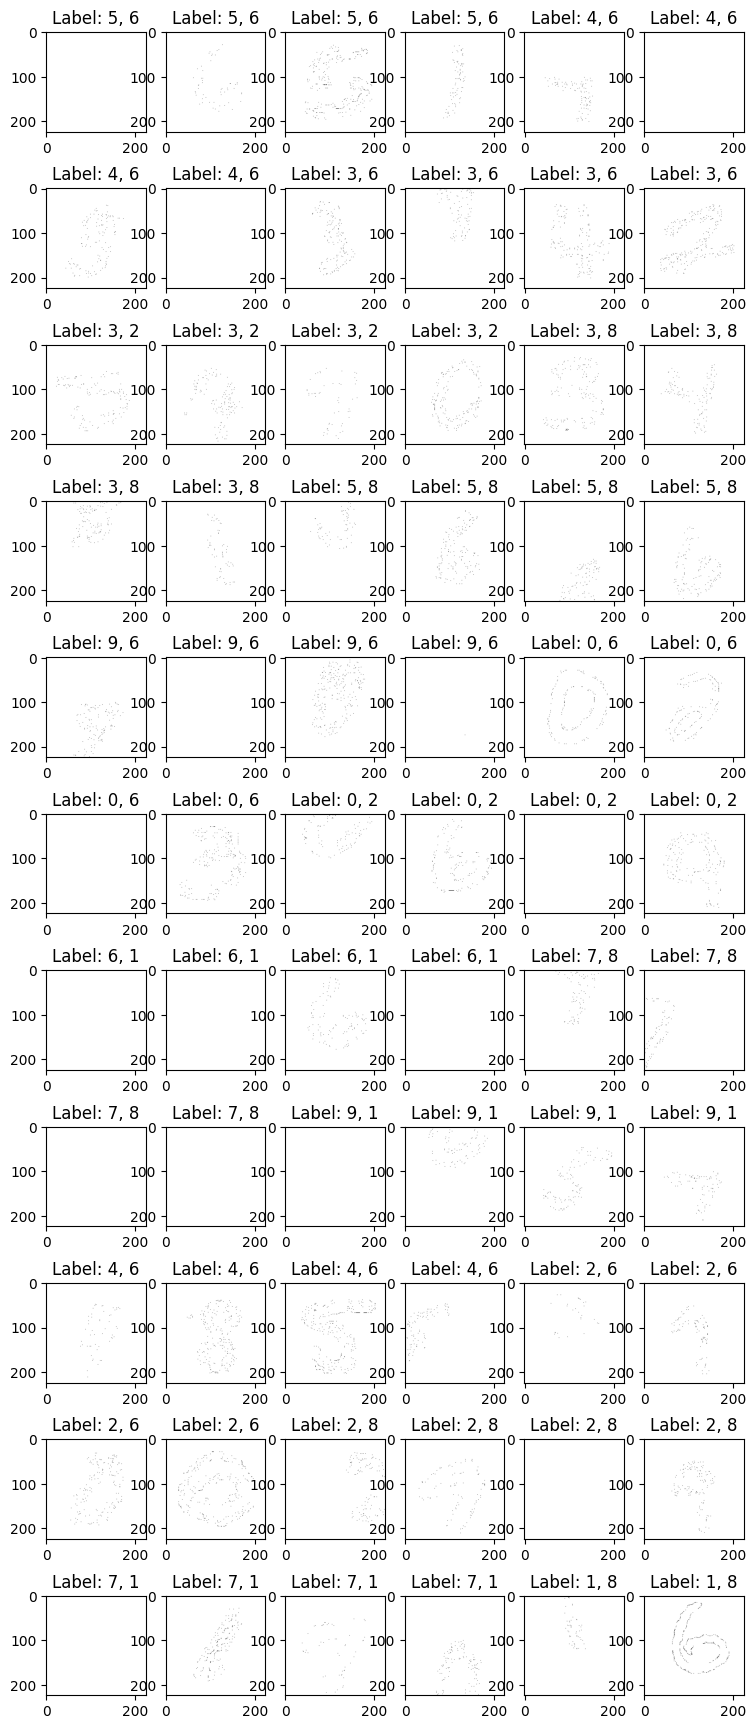

In [ ]:
# mislabeled_image = np.fromfile("mislabeled_images")
aug_images = []
labels = []
for i in range(0, len(mislabeled_image), 25):
  img, t_y, p_y = mislabeled_image[i]
  for j in range(4):
    aug_images.append(img[0][j].reshape(3, 224, 224))
    labels.append(str(t_y) + ", " + str(p_y))

print(len(aug_images))
plot_set_images(11, 6, aug_images, labels, "Label: ")

In [ ]:
aug_images = []
labels = []
for i in range(15, len(mislabeled_image), 25):
  img, t_y, p_y = mislabeled_image[i]
  for j in range(4):
    aug_images.append(img[0][j].reshape(3, 224, 224))
    labels.append(str(t_y) + ", " + str(p_y))

print(len(aug_images))
plot_set_images(11, 6, aug_images, labels, "Label: ")

In [ ]:
aug_images = []
labels = []
for i in range(200, len(mislabeled_image), 400):
  img, t_y, p_y = mislabeled_image[i]
  for i in range(4):
    aug_images.append(img[0].reshape(3, 224, 224))
    labels.append(str(t_y) + ", " + str(p_y))

print(len(aug_images))
plot_set_images(12, 6, aug_images, labels, "Label: ")

In [ ]:
aug_images = []
labels = []
for i in range(20, len(mislabeled_image), 26):
  img, t_y, p_y = mislabeled_image[i]
  for j in range(4):
    aug_images.append(img[0][j].reshape(3, 224, 224))
    labels.append(str(t_y) + ", " + str(p_y))

print(len(aug_images))
plot_set_images(12, 6, aug_images, labels, "Label: ")

In [ ]:
aug_images = []
labels = []
for i in range(350, len(mislabeled_image), 400):
  img, t_y, p_y = mislabeled_image[i]
  for i in range(4):
    aug_images.append(img[0].reshape(3, 224, 224))
    labels.append(str(t_y) + ", " + str(p_y))

print(len(aug_images))
plot_set_images(12, 6, aug_images, labels, "Label: ")